In [1]:
from Peak_Search_Linien import ini_peak_search, mod_peak_search,zero_measure,fir_measure
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from linien_utils import get_waveform, set_scan_range
from linien_client.connection import LinienClient
from scipy.signal import find_peaks

import time
import tqdm
import csv


Linien Offset


[-0.20301619  0.18310253]


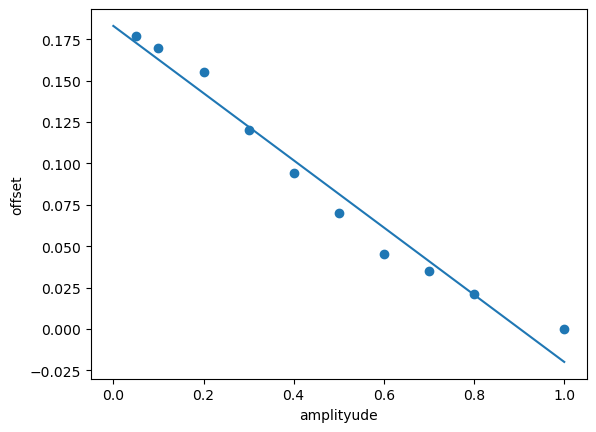

In [2]:
x=[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
y=[0,0.021,0.035,0.045,0.07,0.094,0.12,0.155,0.17,0.177]
xs=np.linspace(0,1,100)
poly = np.polyfit(x,y,1)
poly_y = np.poly1d(poly)(xs)
plt.scatter(x,y)
plt.plot(xs,poly_y)
plt.xlabel("amplityude")
plt.ylabel("offset")
print(poly)

In [2]:
resource_name_windfreak = "COM8"
synthd = SynthHD(resource_name_windfreak)
synthd.init()
rf_out = 0
c = LinienClient(
    host="10.10.222.30",
    user="root",
    password="root"
)
c.connect(autostart_server=True, use_parameter_cache=True)


Try to connect to 10.10.222.30:18862
Connection established!


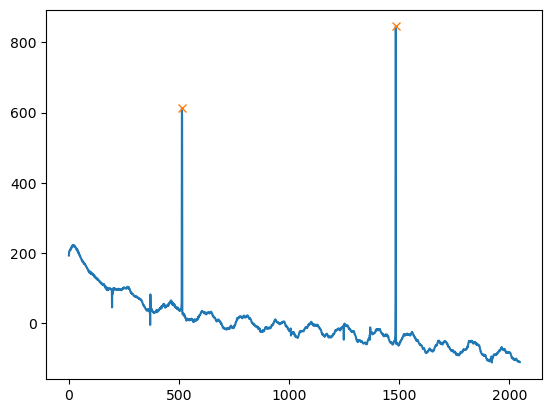

In [7]:
ini_rev_data=get_waveform(c)
plt.plot(ini_rev_data)
ini_peak, _ = find_peaks(ini_rev_data, threshold=10, prominence=100)
plt.plot(ini_peak,ini_rev_data[ini_peak],"x")

In [4]:
synthd.close()

Peak Search

In [4]:
synthd[rf_out].enable = False
zero_amp_all = []
fir_amp_all = []
pow_max_all = []
scan_data = []
power_scan = np.linspace(-15, 8, 50)
fre_scan = np.linspace(1700e6,2700e6,1)

fir_amps = []

for rf_fre in fre_scan:
    synthd[rf_out].enable = False
    ini_peak, ini_reso = ini_peak_search(c)
    # print(ini_peak/1024-1)
    # print(ini_peak)
    zero_amp = []
    fir_amp = []
    synthd[rf_out].enable = True
    for shdpower in tqdm.tqdm(power_scan):
        synthd[rf_out].frequency = rf_fre
        synthd[rf_out].power = shdpower
        set_scan_range(c, 0, 1)
        time.sleep(0.5)
        mod_rev_data  = get_waveform(c)
        mod_peak = mod_peak_search(mod_rev_data)
        mod_zero_peak1, mod_zero_peak2, mod_zero_amp = zero_measure(mod_rev_data, ini_peak, mod_peak, ini_reso)
        # print(mod_zero_peak1/1024-1, 2*mod_zero_peak1/1024-1)
        
        mod_fir_peak, mod_fir_amp = fir_measure(c, mod_rev_data, ini_peak, mod_peak, rf_fre,ini_reso)
        
        zero_amp.append(mod_zero_amp)
        fir_amp.append(mod_fir_amp)
        # time.sleep(1)
    pow_max = power_scan[fir_amp.index(max(fir_amp))]
    scan_data.append([rf_fre,pow_max])
    fir_amps.append(fir_amp)
    pow_max_all.append(pow_max)
    zero_amp_all.append(zero_amp)
    fir_amp_all.append(fir_amp)
    

100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


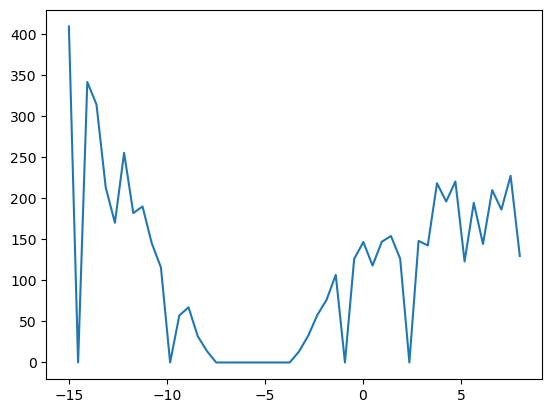

In [ ]:
for i in range(1):
    plt.plot(power_scan,fir_amp_all[i])
    # plt.plot(power_scan,zero_amp_all[i])

In [4]:
synthd[0].enable=False